# Importing packages

In [2]:
from emcee_rapper.mcmcwrapper import MCMCWrapper
import numpy as np
import matplotlib.pyplot as plt

# Linear Fit example
first, define your function such that the first argument is an array of your parameters, and the second argument is your independent variable(s)

In [3]:
def linear_fit(pars, x):
    m, b0 = pars
    return m*x + b0

The package has a core class, `MCMCWrapper`, which you can use to set up and run your MCMC sampling. You need to provide it with your model function, the data you want to fit, the independent variable(s) at which those data were taken, the names from your modeled parameters, an initial guess for those parameters, and some specifications for the prior distributions (more on that later, but the default is uniform priors). 

In [4]:
# make some fake data
true_params = [2.0, -1.0]
x_data = np.linspace(-5, 5, 100)
y_true = linear_fit(true_params, x_data)
np.random.seed(42)
y_obs = y_true + np.random.normal(0, 1.0, size=len(x_data))

In [5]:
# Set up the wrapper
parnames = ["m", "b0"]
initial_guess = [1.0, 0.0]
prior_bounds = [[-10, 10], [-10, 10]]
noise_std = 1.0

wrapper = MCMCWrapper(
    model_function=linear_fit,
    data=y_obs,
    x=x_data,
    varnames=parnames,
    varvalues=initial_guess,
    priorvars=prior_bounds,
    noise=noise_std
)

# This line runs the sampler and prints the median and error bars for each parameter
sampler = wrapper.run_mcmc(nwalkers=30, nsteps=1000)

You must install the tqdm library to use progress indicators with emcee


m: 2.016 (+0.035/-0.035)
b0: -1.104 (+0.101/-0.098)


## Exploring the best fit:
first, we can plot the data and fit themselves (no built-in support but we can do it ourselves)

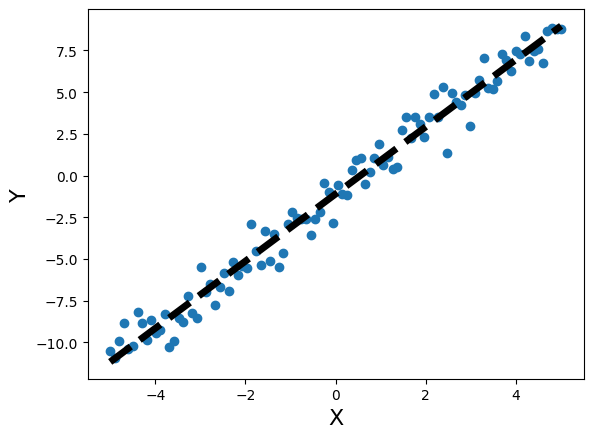

In [6]:
samples = sampler.get_chain(discard=200, thin=15, flat=True)

medians = np.median(samples, axis=0)

fig, ax = plt.subplots()
ax.plot(x_data,y_obs, 'o')
ax.plot(x_data, linear_fit([medians[0], medians[1]], x_data), 'k--', lw=5)
plt.xlabel('X', size=16)
plt.ylabel('Y', size=16)
plt.show()

We do have built-in support for corner plots (using ``corner``) of the posterior distributions and chains of the walkers, however:

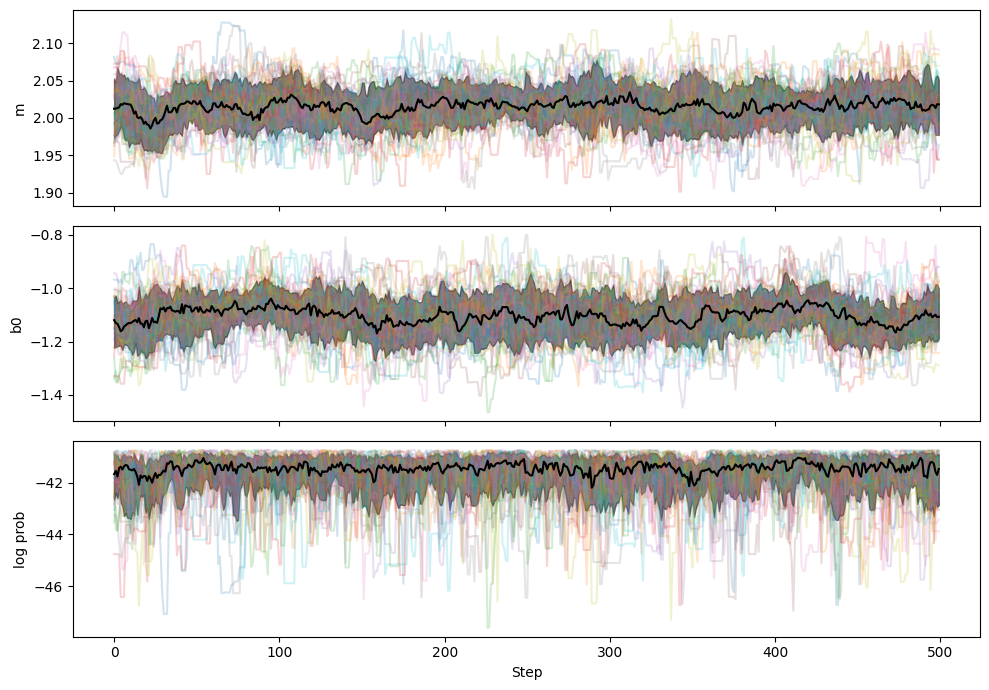

In [7]:
wrapper.walker_plot(discard=500)

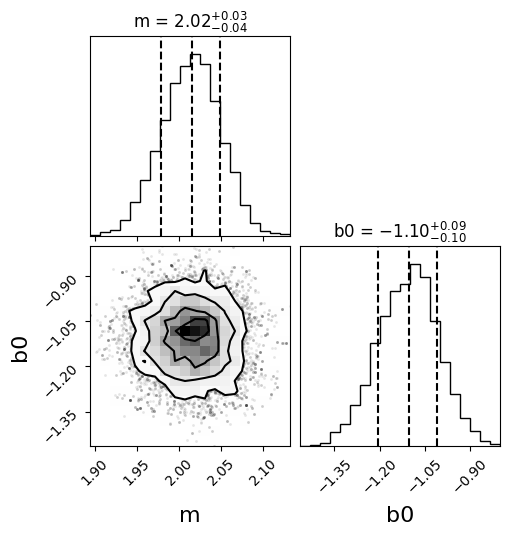

In [8]:
wrapper.corner_plot(discard = 500)

# Quadratic Fit
Here's a similar example with a quadratic fit:

In [9]:
def quadratic_fit(pars, x):
    a, b, c = pars
    return a * x**2 + b * x + c

true_params = [2.0, -1.0, 0.5]
x_data = np.linspace(-5, 5, 100)
y_true = quadratic_fit(true_params, x_data)
np.random.seed(42)
y_obs = y_true + np.random.normal(0, 1.0, size=len(x_data))

parnames = ["a", "b", "c"]
initial_guess = [1.0, 0.0, 0.0]
prior_bounds = [[-10, 10], [-10, 10], [-10, 10]]
noise_std = 1.0

wrapper = MCMCWrapper(
    model_function=quadratic_fit,
    data=y_obs,
    x=x_data,
    varnames=parnames,
    varvalues=initial_guess,
    priorvars=prior_bounds,
    noise=noise_std,
    priortype='uniform'
)

sampler = wrapper.run_mcmc(nwalkers=30, nsteps=1000)

You must install the tqdm library to use progress indicators with emcee


a: 2.008 (+0.013/-0.014)
b: -0.986 (+0.034/-0.038)
c: 0.334 (+0.147/-0.157)


## Best Fit

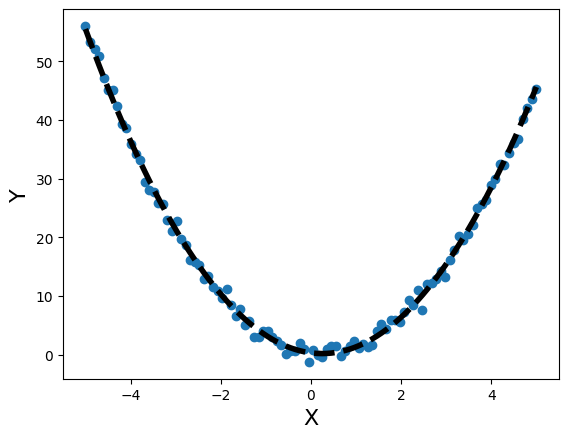

In [10]:
samples = sampler.get_chain(discard=200, thin=15, flat=True)

medians = np.median(samples, axis=0)

plt.plot(x_data,y_obs, 'o')
plt.plot(x_data, quadratic_fit([medians[0], medians[1], medians[2]], x_data), lw=4, ls='--', color='k')
plt.xlabel('X', size=16)
plt.ylabel('Y', size=16)
plt.show()

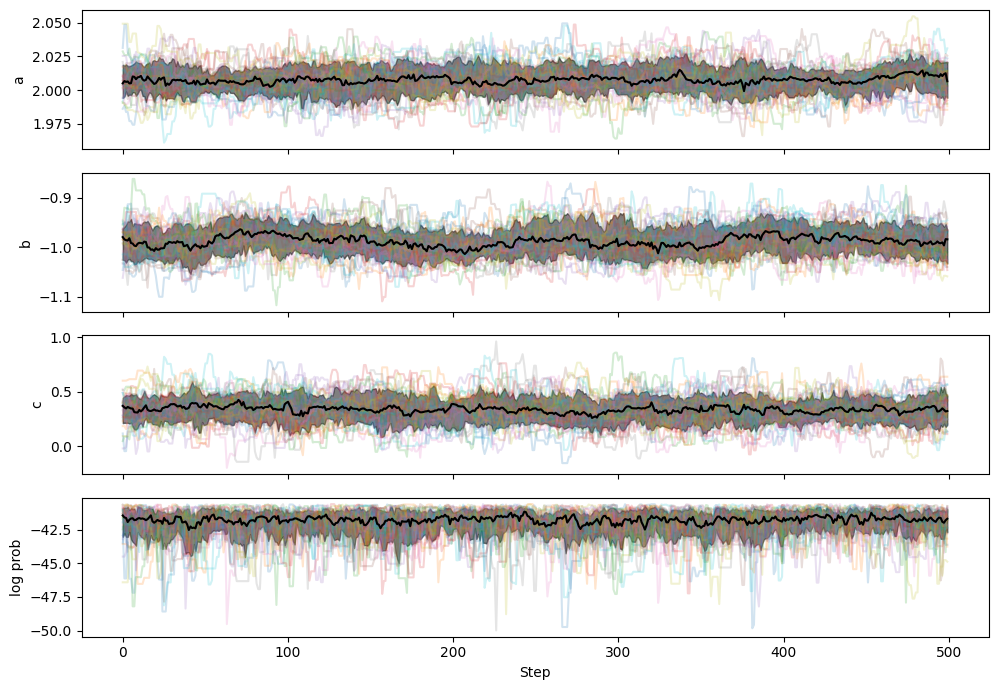

In [11]:
wrapper.walker_plot(discard=500)

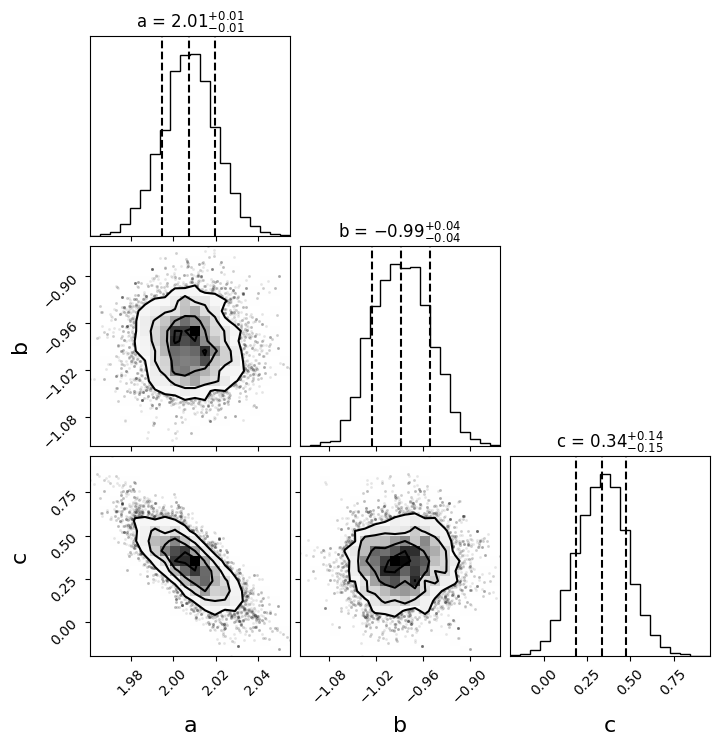

In [12]:
wrapper.corner_plot(discard = 500)

## 2D Fit example

The fitter also works on 2D data! Here we'll try the package out on a 2D dataset (in this case a 2D Gaussian)

In [17]:
def model(pars, x):
	"""2D gaussian centered on a, c with std b and c in x and y, respectively"""
	x0, x1 = x
	a, b, c, d = pars
	return np.exp(-(x0 - a)**2/(b**2)) * np.exp(-(x1-c)**2/(d**2))

true_params = np.array([1.0, 2.0, 1.0, 1.0])
### set up 2 independent vars:
x0_data = np.linspace(-5, 5, 100)
x1_data = np.linspace(-5, 5, 100)
x0_coords, x1_coords = np.meshgrid(x0_data, x1_data)
x0_coords, x1_coords = x0_coords.ravel(), x1_coords.ravel()
coords = np.array([x0_coords, x1_coords])

### make the model and add noise
y_true = model(true_params, coords)
np.random.seed(42)
y_obs = y_true + np.random.normal(0, 0.1, size=len(coords.T))

noise_std = 0.1 # noise assumed by the likelihood

wrapper = MCMCWrapper(
	model_function=model,
	data=y_obs,
	x=coords,
	varnames=["a", "b", "c", "d"],
	varvalues=[0.0, 1.0, 0.0, 1.0],
	priorvars=[[-10., 10.], [-10., 10.], [-10., 10.], [-10., 10.]],
	noise=noise_std,
	priortype=['uniform', 'uniform', 'uniform', 'uniform']
)



sampler = wrapper.run_mcmc(nwalkers=30, nsteps=1000)
samples = sampler.get_chain(discard=200, thin=15, flat=True)

medians = np.median(samples, axis=0)
lower = np.percentile(samples, 16, axis=0)
upper = np.percentile(samples, 84, axis=0)

You must install the tqdm library to use progress indicators with emcee


a: 1.014 (+0.014/-0.012)
b: 1.979 (+0.016/-0.015)
c: 1.003 (+0.006/-0.007)
d: 1.004 (+0.007/-0.008)


(array([[105., 105., 104.,  95., 104., 108.,  89.,  81., 102., 107.],
        [107., 105.,  87.,  96., 104., 101.,  83.,  96., 120., 101.],
        [114.,  91., 100.,  94., 109., 100., 102., 105., 102.,  83.],
        [105.,  82.,  94., 111.,  91., 116., 101.,  97.,  92., 111.]]),
 array([-9.99495091e+00, -7.99560617e+00, -5.99626142e+00, -3.99691668e+00,
        -1.99757193e+00,  1.77281324e-03,  2.00111756e+00,  4.00046230e+00,
         5.99980705e+00,  7.99915179e+00,  9.99849654e+00]),
 <a list of 4 BarContainer objects>)

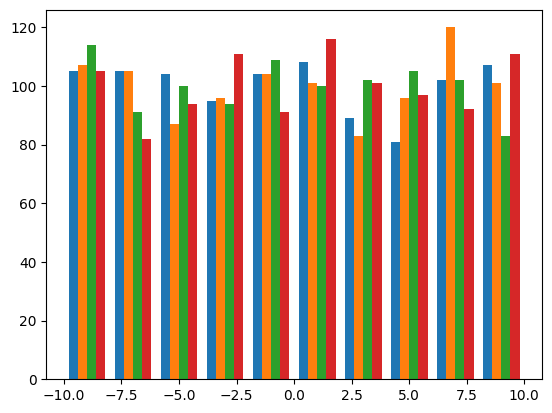

In [18]:
plt.hist(wrapper.sample_priors(1000))

as before, we'll take a look at the chains

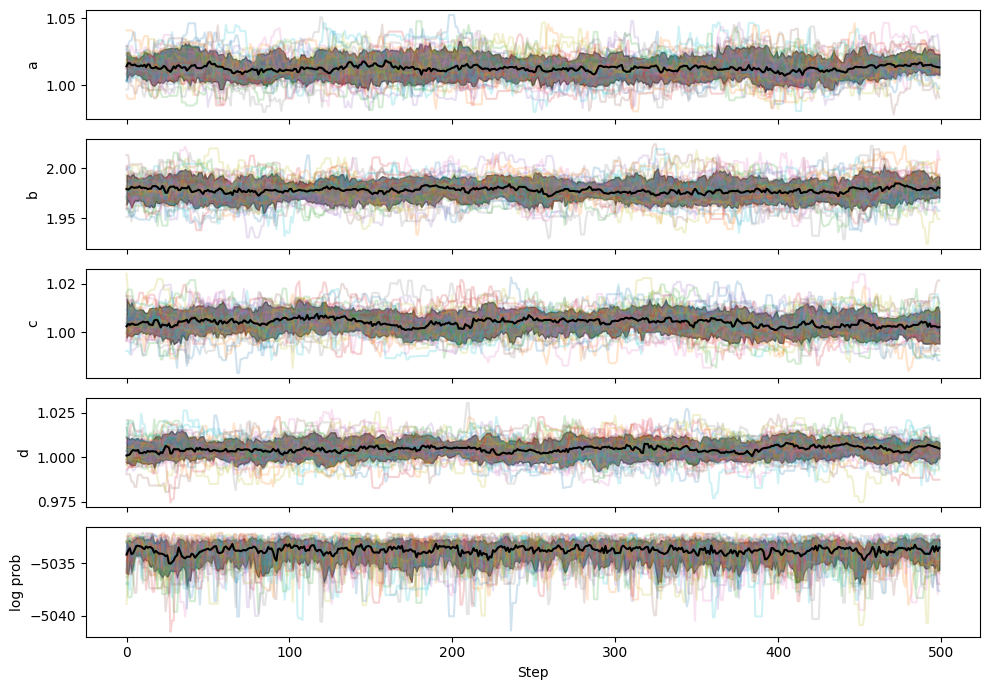

In [19]:
wrapper.walker_plot(discard=500)

We don't have a built-in 2D visualization, but we can plot it ourselves


Text(0.5, 1.0, 'residual')

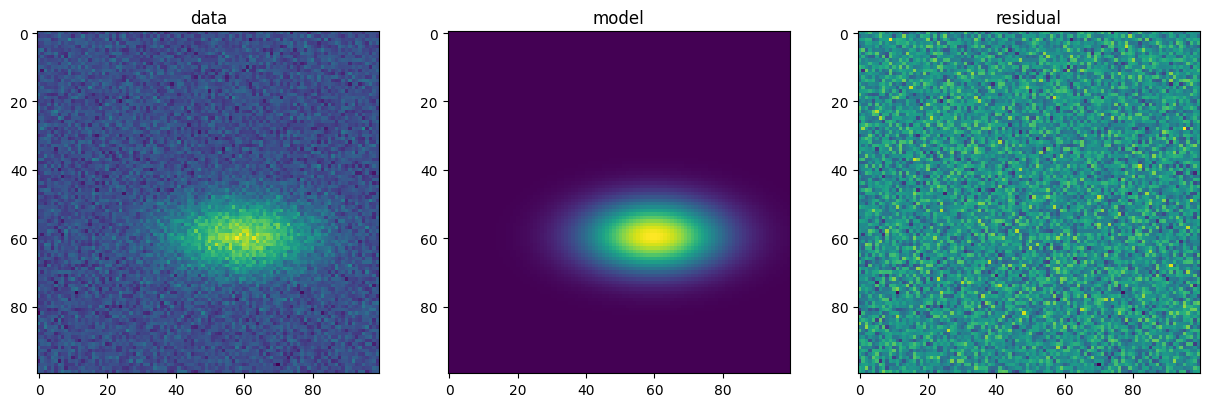

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax[0].imshow(y_obs.reshape((100,100)))
ax[1].imshow(model(medians,coords).reshape((100,100)))
ax[2].imshow(y_obs.reshape((100,100)) - model(medians,coords).reshape((100,100)))
ax[0].set_title('data')
ax[1].set_title('model')
ax[2].set_title('residual')